# KorBERT_NSMC

Department of Statistics, Kyeongwon Lee

* 발표자료는 [github repository](https://github.com/kw-lee/2019compling1/blob/master/KoBERT_NSMC/Presentation.ipynb)에서 확인하실 수 있습니다.

## Environments

* OS: Ubuntu 16.04.5 LTS x86_64
* CPU: Intel Xeon Silver 4110 (32) @ 2.095GHz
* GPU: Nvidia TITAN Xp (use only 1 GPU)

## References

* aisolab: https://github.com/aisolab/nlp_implementation
* [KorBERT_WordPiece](http://aiopen.etri.re.kr/service_dataset.php) from ETRI
    * 학습데이터: 23GB 원시 말뭉치
    * 딥러닝 라이브러리: pytorch, tensorflow
    * 소스코드: tokenizer
    * Latin alphabets: Cased

참고: 

* `bert_eojeol_pytorch/src_tokenizer/tokenization.py`의 `.file_utils`를 `transformers.file_utils`로 변경해야합니다.
* `bert_eojeol_pytorch/bert_config.json`의 맨 마지막에 `"layer_norm_eps": 1e-12`를 추가해야 합니다.

## Libraries

In [1]:
# !pip install -q transformers tqdm future
# !git clone https://github.com/aisolab/nlp_implementation
# !mkdir aisolab
# !cp -r nlp_implementation/BERT_single_sentence_classification/* ./aisolab
# !rm -rf nlp_implementation

In [2]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers.modeling_bert import BertConfig, BertPreTrainedModel, BertModel
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
# from torch.utils.tensorboard import SummaryWriter
import json

import bert_eojeol_pytorch.src_tokenizer.tokenization as tokenization

In [3]:
# from aisolab
from aisolab.model.data import Corpus # easier preprocessing
from aisolab.model.utils import PreProcessor, PadSequence, Vocab # easier preprocessing
from aisolab.model.metric import evaluate, acc # metric
from aisolab.utils import Config, CheckpointManager, SummaryManager # easier configuration

## Data

Using the [Naver sentiment movie corpus](https://github.com/e9t/nsmc) (a.k.a. NSMC)

```bash
    wget -nc -q -O data/train.tsv https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
    wget -nc -q -O data/test.tsv https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1
```

```python
# loading dataset
data_dir = Path("data")
filepath = data_dir / "train.tsv"

dataset = pd.read_csv(filepath, sep="\t").loc[:, ["document", "label"]]
dataset = dataset.loc[dataset["document"].isna().apply(lambda elm: not elm), :]
tr, val = train_test_split(dataset, test_size=0.2, random_state=777)

tr.to_csv(data_dir / "train.txt", sep="\t", index=False)
val.to_csv(data_dir / "validation.txt", sep="\t", index=False)

tst_filepath = data_dir / "test.tsv"
tst = pd.read_csv(tst_filepath, sep="\t").loc[:, ["document", "label"]]
tst = tst.loc[tst["document"].isna().apply(lambda elm: not elm), :]
tst.to_csv(data_dir / "test.txt", sep="\t", index=False)
```

In [4]:
df = pd.read_csv('data/train.tsv', sep='\t')
df.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


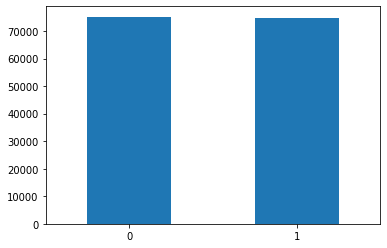

In [5]:
ax = df['label'].value_counts().plot.bar(rot = 0)

## Data Preprocessing

Loading BertTokenizer

In [6]:
data_dir = Path('data')
model_dir = Path('model')
ptr_dir = Path('bert_eojeol_pytorch') # downloaded frem ETRI
ptr_config_path = ptr_dir / 'bert_config.json'
ptr_tokenizer_path = ptr_dir / "vocab.korean.rawtext.list"
ptr_bert_path = ptr_dir / "pytorch_model.bin"

In [7]:
ptr_tokenizer = tokenization.BertTokenizer.from_pretrained(
    ptr_tokenizer_path, do_lower_case=False
)

generate `vocab` (vocabulary)

In [8]:
idx_to_token = list(ptr_tokenizer.vocab.keys())
token_to_idx = {token: idx for idx, token in enumerate(idx_to_token)}

vocab = Vocab(
    idx_to_token,
    padding_token="[PAD]",
    unknown_token="[UNK]",
    bos_token=None,
    eos_token=None,
    reserved_tokens=["[CLS]", "[SEP]", "[MASK]"],
    token_to_idx=token_to_idx,
)

save `vocab`

In [9]:
ptr_vocab_path = ptr_dir / "vocab_etri.pkl"
with open(ptr_vocab_path, mode="wb") as io:
    pickle.dump(vocab, io)

### Configs

In [10]:
data_config = Config(
    {
        "train": str(data_dir / "train.txt"),
        "validation": str(data_dir / "validation.txt"),
        "test": str(data_dir / "test.txt"),
    }
)
data_config.save(data_dir / "config.json")

ptr_config = Config({'config': str(ptr_config_path),
                     'bert': str(ptr_bert_path),
                     'tokenizer': str(ptr_tokenizer_path),
                     'vocab': str(ptr_vocab_path)})
ptr_config.save(ptr_dir / "config.json")

model_config = Config({
  "num_classes": len(df['label'].value_counts()),
  "length": 64,
  "epochs": 5,
  "batch_size": 128,
  "learning_rate": 1e-3,
  "summary_step": 500,
})
model_config.save(model_dir / "config.json")

### Tokenizing

In [11]:
vocab.to_indices(vocab.padding_token)

0

* padding:
    * `aisolab.model.utils`의 `PadSequence()` 함수를 이용
    * padding length = 64
    * padding value = 0
* tokenizer:
    * `aisolab.model.utils`의 `PreProcessor()` 함수를 이용
    * `ptr_tokenizer.tokenize`를 이용해 tokenize, `vacab` 단어에 맞게 mapping, `pad_sequence`대로 pad_sequence를 붙이기

In [12]:
pad_sequence = PadSequence(
    length = model_config.length, 
    pad_val = vocab.to_indices(vocab.padding_token))
preprocessor = PreProcessor(
    vocab = vocab, 
    split_fn = ptr_tokenizer.tokenize, 
    pad_fn = pad_sequence)

In [13]:
preprocess_test = torch.tensor([preprocessor.preprocess('신은 인간을 만들었고, 인간은 클레멘타인을 만들었다'), 
              preprocessor.preprocess('사상최악의 영화! 빵점줄수없는게 아쉽다.. 보다가 돌렸다 그냥 어휴 눈썩어')])
preprocess_test

tensor([[    2,    67,    18,  3304,    12,  1967,  3800,     8,  3304,    18,
           591,   193,  2040,   141,  1104, 12747,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [    2,    35,    64,   212,   504,    11,  1041,  1325,  4185,   204,
           631,    40,   434,   598,   113,    53,  3740,    33,    42,     7,
            60,  1568,   466,  6923,  3559,    62,   804,     9,   555,  4832,
           255,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0

In [ ]:
good_example = [vocab.to_tokens(preprocess_test[0][i]) for i in range(len(preprocess_test[0]))]
for i in good_example:
    print(i, end=", ")

In [ ]:
bad_example = [vocab.to_tokens(preprocess_test[1][i]) for i in range(len(preprocess_test[1]))]
for i in bad_example:
    print(i, end=", ")

## Model

`token` -> `Pretrained-Model` -> `ReLU` with dropout -> `FC` -> `softmax`

In [14]:
config = BertConfig(ptr_config.config)

In [15]:
config

{
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30797
}

In [16]:
# from aisolab/model/net.py
class SentenceClassifier(BertPreTrainedModel):
    def __init__(self, config, num_classes, vocab) -> None:
        super(SentenceClassifier, self).__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.linear = nn.Linear(config.hidden_size, num_classes)
        self.vocab = vocab
        self.relu = nn.ReLU()
        self.init_weights()
    

    def forward(self, input_ids):
        attention_mask = input_ids.ne(self.vocab.to_indices(self.vocab.padding_token)).float()
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask = attention_mask)
        pooled_output = self.dropout(pooled_output)
        relu_output = self.relu(pooled_output)
        logits = self.linear(relu_output) # before sigmoid
        
        return logits

## Train the Model

In [17]:
# for reproducibility
torch.manual_seed(777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### DataLoader

In [18]:
tr_ds = Corpus(data_config.train, preprocessor.preprocess)
tr_dl = DataLoader(tr_ds, batch_size=model_config.batch_size, shuffle=True, num_workers=4, drop_last=True)
val_ds = Corpus(data_config.validation, preprocessor.preprocess)
val_dl = DataLoader(val_ds, batch_size=model_config.batch_size, num_workers=4)

### Model

In [19]:
model = SentenceClassifier(
    config, 
    num_classes = model_config.num_classes,
    vocab = preprocessor.vocab)

In [20]:
bert_pretrained = torch.load(ptr_config.bert)
model.load_state_dict(bert_pretrained, strict = False)

_IncompatibleKeys(missing_keys=['linear.weight', 'linear.bias'], unexpected_keys=['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias'])

### Optimizer

* loss = CrossEntropyLoss
* Adam with learning rate
    * pretrained model: `lr` / 100
    * user-defined model: `lr`

In [21]:
print('lr: {}'.format(model_config.learning_rate))

lr: 0.001


In [22]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(
    [
        {"params": model.bert.parameters(), "lr": model_config.learning_rate / 100},
        {"params": model.linear.parameters(), "lr": model_config.learning_rate}
    ], 
    weight_decay=5e-4)

### Training

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# writer = SummaryWriter('{}/runs_{}'.format(model_dir, 'ETRI'))
checkpoint_manager = CheckpointManager(model_dir)
summary_manager = SummaryManager(model_dir)
best_val_loss = 1e+10

In [24]:
for epoch in tqdm_notebook(range(model_config.epochs), desc='epochs'):

    tr_loss = 0
    tr_acc = 0

    model.train()
    for step, mb in tqdm_notebook(enumerate(tr_dl), desc='steps', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        opt.zero_grad()
        y_hat_mb = model(x_mb)
        mb_loss = loss_fn(y_hat_mb, y_mb)
        mb_loss.backward()
        opt.step()

        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)

        tr_loss += mb_loss.item()
        tr_acc += mb_acc.item()
        
#         writer.add_scalars('train', {'loss': tr_loss / (step + 1),
#                             'acc': tr_acc / (step + 1)}, epoch * len(tr_dl) + step)

        if (epoch * len(tr_dl) + step) % model_config.summary_step == 0:
            tr_summary = {'loss': tr_loss / (step+1), 'acc': tr_acc / (step+1)}
            val_summary = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
#             writer.add_scalars('val', {'loss': val_summary['loss'],
#                                         'acc': val_summary['acc']}, epoch * len(tr_dl) + step)
            tqdm.write('global_step: {:3}, tr_loss: {:.3f}, val_loss: {:.3f}, '
                       'tr_acc: {:.3f}, val_acc: {:.3f}'.format(epoch * len(tr_dl) + step,
                                                                tr_summary['loss'], val_summary['loss'],
                                                               tr_summary['acc'], val_summary['acc']))
            is_best = val_summary['loss'] < best_val_loss
            model.train()


        if is_best:
            state = {'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'opt_state_dict': opt.state_dict()}
            summary = {'train': tr_summary, 'validation': val_summary}
            summary_manager.update(summary)
            summary_manager.save('summary_etri.json')
            checkpoint_manager.save_checkpoint(state, 'best_etri.tar')

            best_val_loss = val_summary['loss']
            model.train()

steps: 100%|██████████| 235/235 [00:48<00:00,  4.83it/s]


global_step:   0, tr_loss: 0.684, val_loss: 0.710, tr_acc: 0.570, val_acc: 0.497


steps: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


global_step: 500, tr_loss: 0.347, val_loss: 0.285, tr_acc: 0.845, val_acc: 0.882



steps: 100%|██████████| 235/235 [00:49<00:00,  4.71it/s]


global_step: 1000, tr_loss: 0.248, val_loss: 0.266, tr_acc: 0.900, val_acc: 0.889


steps: 100%|██████████| 235/235 [00:49<00:00,  4.72it/s]


global_step: 1500, tr_loss: 0.249, val_loss: 0.276, tr_acc: 0.897, val_acc: 0.889



steps: 100%|██████████| 235/235 [00:52<00:00,  4.52it/s]


global_step: 2000, tr_loss: 0.198, val_loss: 0.255, tr_acc: 0.920, val_acc: 0.896


steps: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


global_step: 2500, tr_loss: 0.205, val_loss: 0.246, tr_acc: 0.916, val_acc: 0.900



steps: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


global_step: 3000, tr_loss: 0.168, val_loss: 0.273, tr_acc: 0.934, val_acc: 0.899


steps: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s]


global_step: 3500, tr_loss: 0.171, val_loss: 0.264, tr_acc: 0.932, val_acc: 0.901



steps: 100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


global_step: 4000, tr_loss: 0.136, val_loss: 0.269, tr_acc: 0.949, val_acc: 0.899


steps: 100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


global_step: 4500, tr_loss: 0.140, val_loss: 0.292, tr_acc: 0.947, val_acc: 0.901




![train_loss](./figs/train_loss.png)

![validation_loss](./figs/val_loss.png)

## Test

### Test Data

In [25]:
# model (restore)
checkpoint_manager = CheckpointManager(model_dir)
checkpoint = checkpoint_manager.load_checkpoint('best_etri.tar')
config = BertConfig(ptr_config.config)

model = SentenceClassifier(
    config, 
    num_classes = model_config.num_classes,
    vocab = preprocessor.vocab)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# evaluation
test_ds = Corpus(data_config.test, preprocessor.preprocess)
test_dl = DataLoader(test_ds, batch_size=model_config.batch_size, num_workers=4)

summary = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager.load('summary_etri.json')
summary_manager.update({'etri': summary})
summary_manager.save('summary_etri.json')

print('loss: {:.3f}, acc: {:.2%}'.format(summary['loss'], summary['acc']))

steps: 100%|██████████| 391/391 [01:26<00:00,  4.54it/s]

loss: 0.267, acc: 89.88%


### Real Data - Clementine, 2004

![](./figs/clementine.png)

In [27]:
example = [
    '모니터도 울고 외장하드도 울고 숨어있던 바이러스도 울었다',
    '당신이 이 영화를 보지 않았다면 아직 살아있을 이유 하나를 간직하고 있는 것이다',
    '신은 인간을 만들었고, 인간은 클레멘타인을 만들었다',
    '사상최악의 영화! 빵점줄수없는게 아쉽다.. 보다가 돌렸다 그냥 어휴 눈썩어',
    '죽여버려 ...재밋다해서 봤는데 붇여버려 썸녀랑 사이 어색해졌다',
    '추천해준 친구놈의 목을따러 가야겠습니다'
]

with torch.no_grad():
    example_input = [preprocessor.preprocess(seq) for seq in example]
    example_out = model(torch.tensor(example_input).to(device))
    example_pred = example_out.argmax(dim = 1)
    
example_pred

tensor([1, 1, 1, 0, 0, 0], device='cuda:0')